# **Parcial N.1 Inteligencia Artificial**


**Miembros:**
* Wilson Manuel Estrada Ortega **(200098310)**

* Emily Johana Roldan Ripoll **(200162631)**

* Ana Maria Ardila Pacheco **(200159370)**

## **Descripción del examen**

El objetivo de este reto es implementar un algoritmo de Búsqueda A* en Python que permita encontrar una solución a un juego de Rubik’s Race, partiendo de un estado inicial hasta llegar a un estado final como meta.


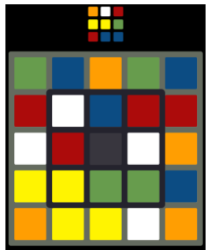

## **Caracteristicas**

- El estado inicial se encuentra definido en un archivo de texto (.txt) y la meta en otro archivo de texto (.txt) diferente.

- Para definir el contenido de cada casilla use las siguientes convenciones: * casilla vacía, B blanco, R rojo, V verde, N naranja, Z azul, A amarillo.


**Movimientos:**


En cada jugada hay máximo cuatro movimientos posibles: (1) Arriba, (2) Abajo, (3) Izquierda y (4) Derecha. Cada movimiento se representa con el número que está entre paréntesis.

- (1) Arriba indica que la ficha que está debajo de la casilla vacía se mueve hacia arriba.

- (2) Abajo indica que la ficha que está arriba de la casilla vacía se mueve hacia abajo.

- (3) Izquierda indica que la ficha que está a la derecha de la casilla vacía se mueve hacia la izquierda.

- (4) Derecha indica que la ficha que está a la izquierde de la casilla vacía se mueve hacia la derecha.



##**Desarrollo de la solución**

### **Carga de archivos**

Lee un archivo y devuelve su contenido en dos formatos:  
1. **Formato original** con saltos de línea.  
2. **Cadena unificada** sin espacios ni saltos de línea.  

**Funcionamiento:**  
- Abre el archivo en modo lectura.  
- Elimina espacios en blanco y líneas vacías.  
- Retorna el contenido en ambos formatos.  
- Maneja errores si el archivo no se encuentra o hay problemas al leerlo.  

In [59]:
import heapq  # Importamos heapq para manejar colas de prioridad (si se usa más adelante)

def cargar_archivo(ruta):
    """Carga un archivo y devuelve su contenido como texto en formato original y como una cadena en una sola línea."""
    try:
        with open(ruta, 'r') as archivo:  # Abrimos el archivo en modo lectura
            lineas = [linea.strip() for linea in archivo if linea.strip()]  # Eliminamos espacios y líneas vacías
            contenido = "\n".join(lineas)  # Mantenemos el formato original con saltos de línea
            contenido_cadena = "".join(lineas)  # Convertimos el contenido en una sola línea
        return contenido, contenido_cadena  # Retornamos el contenido en ambos formatos
    except FileNotFoundError:
        return "El archivo no se encontró.", ""  # Mensaje de error si el archivo no existe
    except Exception as e:
        return f"Ocurrió un error: {e}", ""  # Captura otros errores y los muestra

### **Validación de tableros**

Verifica que los tableros inicial y meta cumplan con las reglas del juego.

**Funcionamiento:**  
- Comprueba que el tablero inicial contenga la celda vacía (`*`).  
- Verifica que el tamaño del tablero inicial sea 25 y el de la meta, 9.  
- Asegura que la celda vacía esté en la posición central (índice 12).  
- Confirma que los caracteres en ambos tableros sean válidos (`B, R, V, N, Z, A`) y (* en el inicial).  
- Se asegura de que ningún carácter aparezca más de 4 veces.  

Si todo es correcto, retorna `True`; en caso contrario, `False`.  



In [60]:
def validar_tableros(tablero_meta, tablero_inicial):
    """Valida si los tableros inicial y meta cumplen con las reglas establecidas."""
    caracteres_validos = {'B', 'R', 'V', 'N', 'Z', 'A'}  # Conjunto de caracteres permitidos
    celda_vacia = '*'  # Representación de la celda vacía

    if celda_vacia not in tablero_inicial: return False  # La celda vacía debe estar en el tablero inicial
    if len(tablero_inicial) != 25 or len(tablero_meta) != 9: return False  # Verificar tamaño de los tableros
    if tablero_inicial[12] != celda_vacia: return False  # La celda vacía debe estar en la posición 13 del string, 12 en python

    if any(c not in caracteres_validos and c != celda_vacia for c in tablero_inicial): return False  # Validar caracteres iniciales
    if any(c not in caracteres_validos for c in tablero_meta): return False  # Validar caracteres de la meta

    for c in caracteres_validos:
        if tablero_inicial.count(c) > 4 or tablero_meta.count(c) > 4: return False  # Ningún carácter debe aparecer más de 4 veces

    return True  # Si pasa todas las validaciones, retorna True

### **Ubicación del espacio vacío**

La función `encontrar_vacio` localiza la posición de la celda vacía (`*`) dentro del tablero. Dado que el tablero es una cadena de caracteres, se usa el método `.index()` para obtener la primera aparición de `*`, que representa la casilla vacía.

**Funcionamiento:**  
- Busca en el tablero el carácter `*`.  
- Retorna la posición (índice) donde se encuentra.  


In [61]:
def encontrar_vacio(tablero):
    """Encuentra la posición del espacio vacío (*) en el tablero."""
    return tablero.index("*")  # Retorna el índice donde se encuentra el carácter '*'

### **Generación de movimientos del espacio vacío**

La función `generar_movimientos` obtiene la posición de la celda vacía (`*`) dentro del tablero y calcula los posibles movimientos intercambiándola con las fichas adyacentes. Se define un tablero de 5x5 y se asignan direcciones de movimiento: arriba, abajo, izquierda y derecha. Luego, se validan los límites del tablero para evitar movimientos inválidos y se generan nuevas configuraciones del tablero resultantes de cada movimiento.

**Funcionamiento:**  
- Se localiza el índice de `*`.  
- Se determinan los movimientos válidos según la posición.  
- Se intercambia `*` con la ficha correspondiente para cada movimiento posible.  
- Se devuelve una lista con los tableros generados y el tipo de movimiento realizado.  




In [62]:
def generar_movimientos(tablero):
    """Genera los posibles movimientos del espacio vacío (*) en el tablero."""
    idx = encontrar_vacio(tablero)  # Encuentra la posición actual del espacio vacío (*)
    filas, cols = 5, 5  # Definimos el tamaño del tablero (5x5)
    x, y = divmod(idx, cols)  # Convertimos el índice en coordenadas (fila, columna)
    movimientos = []  # Lista donde almacenaremos los tableros resultantes tras los movimientos

    # Diccionario con los desplazamientos posibles:
    # 1: Arriba (-5 posiciones), 2: Abajo (+5 posiciones), 3: Izquierda (-1), 4: Derecha (+1)
    direcciones = {1: -cols, 2: cols, 3: -1, 4: 1}

    for mov, d in direcciones.items():
        new_idx = idx + d  # Calculamos la nueva posición después del movimiento

        # Verificamos que el movimiento sea válido:
        # - Que el nuevo índice esté dentro de los límites del tablero
        # - Que no se mueva a la izquierda si está en la primera columna
        # - Que no se mueva a la derecha si está en la última columna
        if 0 <= new_idx < len(tablero) and not (y == 0 and mov == 3) and not (y == 4 and mov == 4):
            nuevo_tablero = list(tablero)  # Convertimos la cadena en una lista para modificarla
            nuevo_tablero[idx], nuevo_tablero[new_idx] = nuevo_tablero[new_idx], "*"  # Intercambiamos posiciones
            movimientos.append(("".join(nuevo_tablero), mov))  # Agregamos el nuevo tablero y el movimiento

    return movimientos  # Retornamos la lista de posibles tableros tras los movimientos

### **Extracción de la zona central**

La función `extraer_zona_central` obtiene los 9 caracteres que conforman la parte central del tablero 5x5. Para ello, selecciona y concatena los elementos de las tres filas intermedias.

**Funcionamiento:**  
- Se extraen los caracteres de las posiciones 6 a 8, 11 a 13 y 16 a 18.  
- Se concatenan en una sola cadena, representando la zona central del tablero.  

In [63]:
def extraer_zona_central(tablero):
    """Extrae los 9 caracteres de la zona central del tablero 5x5."""
    return tablero[6:9] + tablero[11:14] + tablero[16:19]  # Tomamos las filas centrales y las concatenamos

### **Cálculo de heurística**

La función `heuristica` evalúa qué tan lejos está el tablero actual del estado meta, contando las fichas mal ubicadas en la zona central.

**Funcionamiento:**  
- Se extrae la zona central del tablero.  
- Se compara con la meta y se cuentan las fichas en posiciones incorrectas.  
- Retorna el número de fichas mal colocadas como medida de la heurística.  

In [64]:
def heuristica(tablero, meta):
    """Calcula la heurística basada en fichas mal ubicadas en la zona central."""
    zona = extraer_zona_central(tablero)  # Extraemos la zona central del tablero actual
    return sum(1 for i in range(9) if zona[i] != meta[i])  # Contamos cuántas fichas están mal ubicadas

### **Formato visual del tablero**  

#### **Función `imprimir_tablero`**  
Esta función transforma una cadena lineal en un tablero de 5x5 con bordes y separadores.  

**Funcionamiento:**  
- Divide la cadena en segmentos de 5 caracteres para formar filas.  
- Construye una estructura con líneas horizontales (`+---+`) y separadores verticales (`|`).  
- Retorna una representación en texto del tablero con saltos de línea.  

#### **Función `imprimir_tablero_colores`**  
Esta función muestra un tablero de 5x5 con colores y resalta el área central 3x3 con un borde marrón. Está diseñada para ejecutarse en entornos como Google Colab o Jupyter Notebook.  

**Funcionamiento:**  
- Asigna colores a cada tipo de letra mediante un diccionario.  
- Divide la cadena en filas de 5 caracteres para construir la estructura del tablero.  
- Usa HTML y CSS para crear una tabla con estilo visual atractivo.  
- Resalta el área central 3x3 con un borde marrón más grueso.  
- Reemplaza los `'*'` con celdas vacías y un fondo blanco.  
- Muestra la tabla en Jupyter Notebook o Google Colab usando `display(HTML())`.  


In [65]:
def imprimir_tablero(tablero):
    """Devuelve el tablero en formato visual de 5x5 con bordes y separadores."""
    filas = [tablero[i:i+5] for i in range(0, 25, 5)]  # Divide la cadena en bloques de 5 caracteres (filas)
    separador = "+---" * 5 + "+"  # Crea la línea separadora horizontal con bordes
    resultado = [separador]  # Inicia la lista con la primera línea separadora
    for fila in filas:
        resultado.append("| " + " | ".join(fila) + " |")  # Construye la fila con separadores verticales
        resultado.append(separador)  # Agrega la línea separadora después de cada fila
    return "\n".join(resultado)  # Une todas las líneas en un solo string con saltos de línea


from IPython.core.display import display, HTML  # Importar las funciones necesarias para mostrar HTML en Colab
def imprimir_tablero_colores(tablero):
    """Imprime el tablero 5x5 con colores y resalta el área central 3x3 con un borde marrón."""
    colores = {  # Diccionario que asigna colores a cada letra del tablero
        'V': 'green',   # Verde para 'V'
        'Z': 'blue',    # Azul para 'Z'
        'N': 'gray',    # Gris para 'N'
        'R': 'red',     # Rojo para 'R'
        'B': 'black',   # Negro para 'B'
        'A': 'orange'   # Naranja para 'A'
    }
    filas = [tablero[i:i+5] for i in range(0, 25, 5)]  # Divide el string en filas de 5 caracteres cada una
    html = '<table style="border-collapse: collapse; font-size: 20px; background-color: #f2f2f2; border-radius: 10px; padding: 10px;">'  # Inicia la tabla con estilo
    for i, fila in enumerate(filas):  # Itera sobre cada fila del tablero
        html += '<tr>'  # Inicia una nueva fila en la tabla
        for j, c in enumerate(fila):  # Itera sobre cada celda en la fila
            color = colores.get(c, "black") if c != '*' else "#f2f2f2"  # Obtiene el color correspondiente o gris si es '*'
            contenido = c if c != '*' else ""  # Si es '*', deja la celda vacía
            bg_color = "#ffffff" if c == '*' else "#e6e6e6"  # Color de fondo: blanco si es '*', gris claro en otros casos
            # Verifica si la celda está dentro del área central 3x3
            if 1 <= i <= 3 and 1 <= j <= 3:
                borde = "3px solid brown"  # Aplica un borde marrón grueso si está en el área central
            else:
                borde = "1px solid #ccc"  # Borde normal para el resto de las celdas
            # Agrega la celda a la tabla con el estilo correspondiente
            html += f'<td style="width: 40px; height: 40px; text-align: center; border: {borde}; background-color: {bg_color}; color: {color}; font-weight: bold; border-radius: 5px;">{contenido}</td>'
        html += '</tr>'  # Cierra la fila actual
    html += '</table>'  # Cierra la tabla
    display(HTML(html))  # Muestra la tabla en Jupyter Notebook

### **Traducción de movimientos**

La función `traduce_mov` convierte un número de movimiento en su dirección correspondiente.

**Funcionamiento:**  
- Usa un diccionario para mapear números a direcciones:  
  - 1 → Abajo  
  - 2 → Arriba  
  - 3 → Derecha  
  - 4 → Izquierda  
- Retorna la dirección correspondiente o un mensaje si el número es inválido.  

In [66]:
def traduce_mov(numero):
    """Traduce un número de movimiento a su dirección correspondiente."""
    movimientos = {1: "Abajo", 2: "Arriba", 3: "Derecha", 4: "Izquierda"}  # Mapeo de números a direcciones
    return movimientos.get(numero, "Movimiento inválido")  # Devuelve la dirección o un mensaje si no es válido

### **Algoritmo A***

La función `a_star` implementa el algoritmo A* para encontrar la solución óptima en un tablero.

**Funcionamiento:**  
- Usa una cola de prioridad (`frontera`) para explorar los estados con menor costo estimado.  
- Guarda los estados visitados para evitar ciclos.  
- Expande los movimientos posibles y calcula la heurística.  
- Si encuentra la meta, reconstruye el camino de solución, mostrando y guardando los pasos en `solucion.txt`.  
- Si no hay solución, lo indica en el archivo y en consola.  



In [67]:
def a_star(inicial, meta):
    """Implementación del algoritmo A* para encontrar la solución óptima."""
    frontera = [(heuristica(inicial, meta), 0, inicial, [])]  # Cola de prioridad con (costo estimado, costo real, estado, camino)
    visitados = set()  # Conjunto para almacenar estados visitados

    with open("solucion.txt", "w") as archivo:  # Abre un archivo para guardar la solución
        while frontera:
            _, g, estado_actual, camino = heapq.heappop(frontera)  # Extrae el estado con menor costo estimado

            if extraer_zona_central(estado_actual) == meta:  # Si el estado actual es la meta, se encontró la solución
                total_movs = len(camino)
                actual_mov = 0
                archivo.write("¡Solución encontrada!\n")
                archivo.write(f"Número total de movimientos: {total_movs}\n\n")
                archivo.write("Pasos de la solución:\n")

                print("¡Solución encontrada!")
                print(f"Número total de movimientos: {total_movs}\n")

                estado = inicial
                archivo.write(imprimir_tablero(estado) + "\n\n")
                imprimir_tablero_colores(estado)
                print("")
                print("")
                print("")
                print("")

                for mov in camino:  # Recorre los movimientos realizados para mostrar el proceso paso a paso
                    for nuevo_estado, m in generar_movimientos(estado):
                        if m == mov:
                            actual_mov += 1
                            estado = nuevo_estado
                            archivo.write(f"MOVIMIENTO# {actual_mov}: {traduce_mov(m)} - Heurística: {heuristica(estado, meta)}\n")
                            archivo.write(imprimir_tablero(estado) + "\n\n")
                            print(f"MOVIMIENTO# {actual_mov}: {traduce_mov(m)} - Heurística: {heuristica(estado, meta)}\n")
                            imprimir_tablero_colores(estado)
                            print("")
                            print("")
                            print("")
                            print("")
                            break
                return

            if estado_actual in visitados:  # Si el estado ya fue visitado, se ignora
                continue
            visitados.add(estado_actual)  # Marca el estado como visitado

            for nuevo_estado, mov in generar_movimientos(estado_actual):  # Genera y evalúa los movimientos posibles
                if nuevo_estado not in visitados:
                    heapq.heappush(frontera, (g + 1 + heuristica(nuevo_estado, meta), g + 1, nuevo_estado, camino + [mov]))

        archivo.write("No hay Solución")  # Si se agotan las opciones, no hay solución
        print("No hay solución")

### **Función Principal (`main`)**

Ejecuta el algoritmo A* si los archivos de entrada se cargan correctamente y los tableros son válidos.

**Funcionamiento:**  
- Carga los archivos `meta.txt` y `inicial.txt`.  
- Valida que los tableros cumplan con las reglas establecidas.  
- Si hay errores en la carga o validación, los muestra y termina la ejecución.  
- Si todo es correcto, ejecuta el algoritmo A* para encontrar la solución.  


In [68]:
def main():
    """Función principal que ejecuta el algoritmo A* si los archivos se cargan correctamente y los tableros son válidos."""
    ruta_meta = '/content/meta.txt'
    ruta_inicial = '/content/inicial.txt'

    try:
        contenido_meta, cadena_meta = cargar_archivo(ruta_meta)  # Carga el archivo de la meta
        contenido_inicial, cadena_inicial = cargar_archivo(ruta_inicial)  # Carga el archivo inicial
    except Exception as e:
        print(f"Error al cargar los archivos: {e}")
        return

    if not validar_tableros(cadena_meta, cadena_inicial):
        print('No hay Solución')
        with open("solucion.txt", "w") as archivo:
            archivo.write("No hay Solución")
    else:
        # Si todo está correcto, ejecutar A*
        a_star(cadena_inicial, cadena_meta)

## **Ejecución de la solución**

In [69]:
# Llamar a la función principal
if __name__ == "__main__":
    main()

¡Solución encontrada!
Número total de movimientos: 19



A,B,Z,A,A
B,R,N,V,R
B,Z,,R,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 1: Izquierda - Heurística: 7



A,B,Z,A,A
B,R,N,V,R
B,Z,R,,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 2: Abajo - Heurística: 7



A,B,Z,A,A
B,R,N,,R
B,Z,R,V,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 3: Abajo - Heurística: 7



A,B,Z,,A
B,R,N,A,R
B,Z,R,V,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 4: Derecha - Heurística: 7



A,B,,Z,A
B,R,N,A,R
B,Z,R,V,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 5: Arriba - Heurística: 7



A,B,N,Z,A
B,R,,A,R
B,Z,R,V,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 6: Derecha - Heurística: 7



A,B,N,Z,A
B,,R,A,R
B,Z,R,V,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 7: Abajo - Heurística: 6



A,,N,Z,A
B,B,R,A,R
B,Z,R,V,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 8: Izquierda - Heurística: 6



A,N,,Z,A
B,B,R,A,R
B,Z,R,V,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 9: Arriba - Heurística: 6



A,N,R,Z,A
B,B,,A,R
B,Z,R,V,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 10: Arriba - Heurística: 6



A,N,R,Z,A
B,B,R,A,R
B,Z,,V,N
Z,R,N,A,V
Z,B,V,V,N






MOVIMIENTO# 11: Arriba - Heurística: 5



A,N,R,Z,A
B,B,R,A,R
B,Z,N,V,N
Z,R,,A,V
Z,B,V,V,N






MOVIMIENTO# 12: Izquierda - Heurística: 4



A,N,R,Z,A
B,B,R,A,R
B,Z,N,V,N
Z,R,A,,V
Z,B,V,V,N






MOVIMIENTO# 13: Abajo - Heurística: 3



A,N,R,Z,A
B,B,R,A,R
B,Z,N,,N
Z,R,A,V,V
Z,B,V,V,N






MOVIMIENTO# 14: Abajo - Heurística: 2



A,N,R,Z,A
B,B,R,,R
B,Z,N,A,N
Z,R,A,V,V
Z,B,V,V,N






MOVIMIENTO# 15: Abajo - Heurística: 1



A,N,R,,A
B,B,R,Z,R
B,Z,N,A,N
Z,R,A,V,V
Z,B,V,V,N






MOVIMIENTO# 16: Derecha - Heurística: 1



A,N,,R,A
B,B,R,Z,R
B,Z,N,A,N
Z,R,A,V,V
Z,B,V,V,N






MOVIMIENTO# 17: Arriba - Heurística: 1



A,N,R,R,A
B,B,,Z,R
B,Z,N,A,N
Z,R,A,V,V
Z,B,V,V,N






MOVIMIENTO# 18: Derecha - Heurística: 1



A,N,R,R,A
B,,B,Z,R
B,Z,N,A,N
Z,R,A,V,V
Z,B,V,V,N






MOVIMIENTO# 19: Derecha - Heurística: 0



A,N,R,R,A
,B,B,Z,R
B,Z,N,A,N
Z,R,A,V,V
Z,B,V,V,N


##**Referencias**

Rubik’s Race. (s. f.). https://www.joonas.io/rubik-s-race/